## Random walks on ontologies

We will initially use a set of tools to (a) classify an ontology (with or without an ABox), (b) perform random walks on the ontology, and (c) generate an embedding function using a skip-gram model.

We will use prebuilt tools to generate our first set of embeddings using random walks. First, we process RDF and OWL to convert the data to an edgelist format using this groovy script:

```usage: groovy RDFWrapper
 -c,--classify <arg>             use an OWL reasoner to classify the RDF
                                 dataset (must be in RDF/XML) before graph
                                 generation (default: false)
 -d,--ontology-directory <arg>   directory with ontologies to use for
                                 reasoning
 -f,--format <arg>               RDF format; values are "RDF/XML",
                                 "N-TRIPLE", "TURTLE" and "N3" (default:
                                 RDF/XML)
 -h,--help                       this information
 -i,--input <arg>                input RDF file
 -m,--mapping-file <arg>         output mapping file; has numerical ids
                                 for all entities
 -o,--output <arg>               output file for DeepWalk algorithm
 -u,--undirected <arg>           build undirected graph (default: false)
```

We apply this to a (relatively) small graph of yeast proteins, their interactions, and their GO functions:

In [ ]:
org_id = '4932' # 4932 - yeast, 9606 - human

In [2]:
!groovy walking-rdf-and-owl/RDFWrapper.groovy -i 'data/train/{org_id}.classes-rdf.nt' -o 'data/{org_id}.classes-rdf.list' -m 'data/{org_id}.classes-rdf.map' -f N-TRIPLE

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.
Caught: groovy.lang.GroovyRuntimeException: Ambiguous method overloading for method org.apache.jena.rdf.model.impl.ModelCom#read.
Cannot resolve which method to invoke for [null, null, class java.lang.String] due to overlapping prototypes between:
	[class java.io.InputStream, class java.lang.String, class java.lang.String]
	[class java.io.Reader, class java.lang.String, class java.lang.String]
	[class java.lang.String, class java.lang.String, class java.lang.String]
groovy.lang.GroovyRuntimeException: Ambiguous method overloading for method org.apache.jena.rdf.model.impl.ModelCom#read.
Cannot resolve which method to invoke for [null, null, class java.lang.String] due to overlapping prototypes between:
	[class java.io.InputStream, class java.lang.String, class java.lang.String]
	[

This will generate two new files in the data directory: an edgelist in which nodes and edges are represented by numbers, and a mapping file so we know which number corresponds to which entity (nodes or edges).

Next, we perform random walks on this dataset. You can use a Python implementation or a somewhat faster C++ implementation:

In [2]:
!walking-rdf-and-owl/deepwalk 'data/{org_id}.classes-rdf.list' 'data/{org_id}.classes-rdf.walks'

Building graph from data/yeast-classes-rdf.list
Number of nodes in graph: 10514
Writing walks to data/yeast-classes-rdf.walks
10509 tasks pending.


The result is a file with a set of "walks". These walks form "sentences" that describe the entities in the graph we generated. We use a neural language model (Word2Vec's skipgram model) on these sentences to generate the embeddings. There are many implementations of the skipgram model, we will use Facebook's FastText implementation here as it is one of the fastest.

In [3]:

!fastText/fasttext skipgram -input 'data/{org_id}.classes-rdf.walks' -output 'data/{org_id}.classes-rdf.model' -minCount 1


Read 44M words
Number of words:  10525
Number of labels: 0
Progress: 100.0% words/sec/thread:   59370 lr:  0.000000 loss:  0.703070 ETA:   0h 0m


Now that we have generated the embedding function and the corresponding vectors for each entity (in `data/yeast-classes-rdf.model.vec`), we can use them for other tasks: clustering, similarity-search (using cosine similarity), or as feature vectors. We first read these vectors and the mappings into a dataframe and do some processing.

In [4]:
import numpy as np
import pandas as pd

embeddings = pd.read_csv(f'data/{org_id}.classes-rdf.model.vec', header = None, skiprows = 1, sep = ' ')
embds_data = embeddings.values
embeddings_dict = dict(zip(embds_data[:,0],embds_data[:,1:-1]))

mappings = pd.read_csv(f'data/{org_id}.classes-rdf.map', header = None, sep = '\t')
mps = mappings.values
mappings_dict = dict(zip(mps[:,1],mps[:,0]))

embarr = {}
for item in embeddings_dict:
    if str(item).isdigit():
        if int(item) in mappings_dict:
            ent = mappings_dict[int(item)]
            embarr[ent] = np.array(embeddings_dict[item], dtype = 'float')

size = len(embarr['http://www.w3.org/2000/01/rdf-schema#subClassOf'])
embeds = np.zeros((len(embarr), size), dtype=np.float32)
for i, emb in enumerate(embarr.values()):
    embeds[i, :] = emb
nodemap = {}
for i, m in enumerate(embarr.keys()):
    nodemap[i] = m


/home/borg/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We can now visualize the embedding we generated using a dimensionality reduction method such as TSNE which projects the vectors on two dimensions.

In [5]:
from matplotlib import pyplot as plt
#from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE

X = TSNE(n_components=2, verbose=1, n_iter=2500, n_jobs=8).fit_transform(embeds)


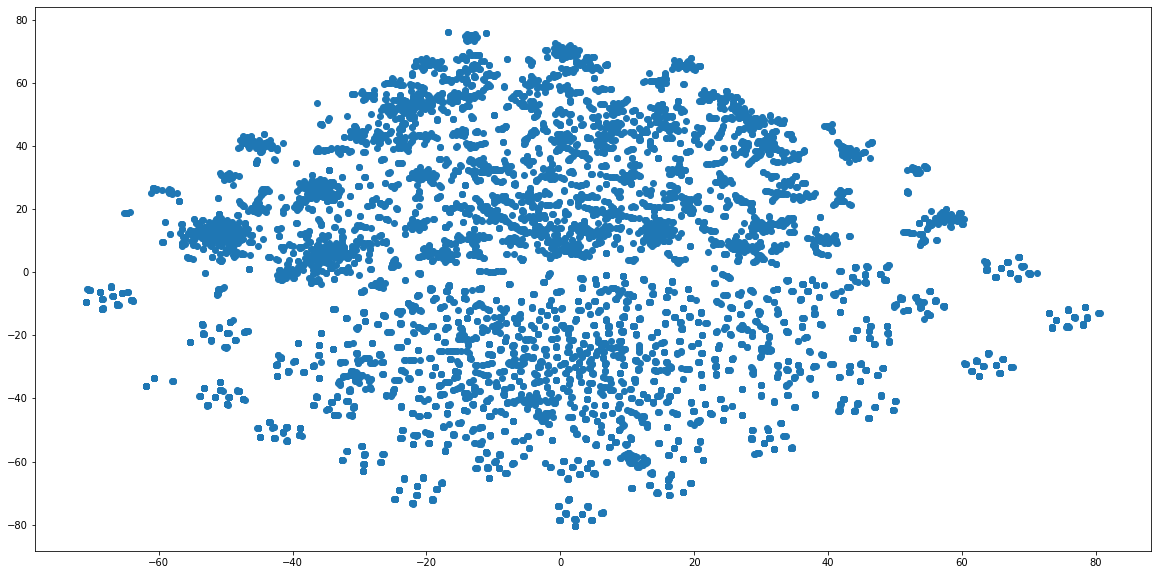

In [6]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(X[:, 0], X[:, 1], marker='o')


This may provide us with an overview, but it is a bit hard to figure out what is going on. So next we only plot the proteins which are enzymes and we also color them based on their EC number.

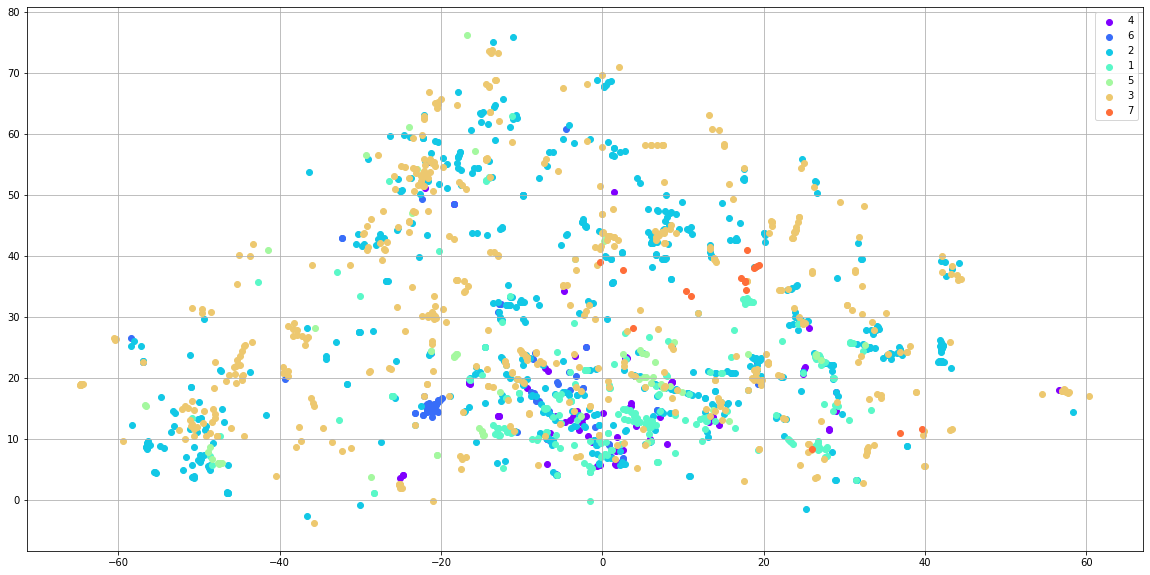

In [7]:
import matplotlib as mpl

ec_numbers = {}
with open('data/yeast_ec.tab') as f:
    next(f)
    for line in f:
        it = line.strip().split('\t', -1)
        if len(it) < 5:
            continue
        if it[3]:
            prot_id = it[3].split(';')[0]
            prot_id = 'http://{0}'.format(prot_id)    
            ec_numbers[prot_id] = it[4]
            
ec_classes = {'0': [[], []]}
for item in nodemap.items():
    k, v = item
    if v in ec_numbers:
        ec = ec_numbers[v].split('.')[0]
        if ec not in ec_classes:
            ec_classes[ec] = [[], []]
        ec_classes[ec][0].append(X[k, 0])
        ec_classes[ec][1].append(X[k, 1])
        
colors = iter(mpl.cm.rainbow(np.linspace(0, 1, len(ec_classes))))
fig, ax = plt.subplots(figsize=(20, 10))

for ec, items in ec_classes.items():
    if ec == '0':
        continue
    color = next(colors)
    ax.scatter(items[0], items[1], color=color, label=ec)

ax.legend()
ax.grid(True)

plt.show()

Visualization is not the only thing we can do with the vectors; we can also do similarity-based search, clustering, or use them as general feature vectors. We can search for similar proteins like this: 

In [8]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

query = 'http://4932.YOR234C'
qemb = ""
for item in nodemap:
    if nodemap[item] == query:
        qemb = embeds[item]

maxsim = 0.0
maxent = ""
for item in nodemap:
    if "4932." in nodemap[item]:
        if nodemap[item] != query:
            emb = embeds[item]
            sim = cosine(emb, qemb)
            if sim > maxsim:
                maxsim = sim
                maxent = nodemap[item]
print(maxent, maxsim)

http://4932.YPL189W 1.0111169470474124


### Task 1: Get top 10 similar proteins for a query protein

In [9]:
query = 'http://4932.YOR234C'

### Evaluation results on test set:
 * Hits@k, k $\in$ {10, 100}
 * Mean rank
 * ROC AUC

In [21]:
from scipy.stats import rankdata

def load_test_data(data_file, classes, relations):
    data = []
    with open(data_file, 'r') as f:
        for line in f:
            it = line.strip().split()
            id1 = f'http://{it[0]}'
            id2 = f'http://{it[1]}'
            if id1 not in classes or id2 not in classes or rel not in relations:
                continue
            data.append((id1, id2))
    return data

def compute_rank_roc(ranks, n_prots):
    auc_x = list(ranks.keys())
    auc_x.sort()
    auc_y = []
    tpr = 0
    sum_rank = sum(ranks.values())
    for x in auc_x:
        tpr += ranks[x]
        auc_y.append(tpr / sum_rank)
    auc_x.append(n_prots)
    auc_y.append(1)
    auc = np.trapz(auc_y, auc_x) / n_prots
    return auc

# Load embeddings from saved files
cls_df = pd.read_pickle(f'data/walks/{org_id}_cls_embeddings.pkl')
rel_df = pd.read_pickle(f'data/walks/{org_id}_rel_embeddings.pkl')
classes = {v: k for k, v in enumerate(cls_df['classes'])}
relations = {v: k for k, v in enumerate(rel_df['relations'])}

nb_classes = len(cls_df)
nb_relations = len(rel_df)
embeds_list = cls_df['embeddings'].values
rembeds_list = rel_df['embeddings'].values
size = len(embeds_list[0])
embeds = np.zeros((nb_classes, size), dtype=np.float32)
for i, emb in enumerate(embeds_list):
    embeds[i, :] = emb

proteins = {}
for k, v in classes.items():
    if not k.startswith('http://GO:'):
        proteins[k] = v

print('Proteins: ', len(proteins))

prot_index = list(proteins.values())
prot_embeds = embeds[prot_index, :]
prot_dict = {v: k for k, v in enumerate(prot_index)}
    
rsize = len(rembeds_list[0])
rembeds = np.zeros((nb_relations, rsize), dtype=np.float32)
for i, emb in enumerate(rembeds_list):
    rembeds[i, :] = emb

# Load training data to computed filtered rank
train_data = load_test_data(f'data/train/{org_id}.protein.links.v11.0.txt', classes, relations)
valid_data = load_test_data(f'data/valid/{org_id}.protein.links.v11.0.txt', classes, relations)
trlabels = {}
for c, r, d in train_data:
    c, r, d = prot_dict[classes[c]], relations[r], prot_dict[classes[d]]
    if r not in trlabels:
        trlabels[r] = np.ones((len(prot_embeds), len(prot_embeds)), dtype=np.int32)
    trlabels[r][c, d] = 1000
for c, r, d in valid_data:
    c, r, d = prot_dict[classes[c]], relations[r], prot_dict[classes[d]]
    if r not in trlabels:
        trlabels[r] = np.ones((len(prot_embeds), len(prot_embeds)), dtype=np.int32)
    trlabels[r][c, d] = 1000


# Load test data and compute ranks for each protein
test_data = load_test_data(f'data/test/{org_id}.protein.links.v11.0.txt', classes, relations)
top1 = 0
top10 = 0
top100 = 0
mean_rank = 0
ftop1 = 0
ftop10 = 0
ftop100 = 0
fmean_rank = 0
labels = {}
preds = {}
ranks = {}
franks = {}
eval_data = test_data
n = len(eval_data)
for c, r, d in eval_data:
    c, r, d = prot_dict[classes[c]], relations[r], prot_dict[classes[d]]
    if r not in labels:
        labels[r] = np.zeros((len(prot_embeds), len(prot_embeds)), dtype=np.int32)
    if r not in preds:
        preds[r] = np.zeros((len(prot_embeds), len(prot_embeds)), dtype=np.float32)
    labels[r][c, d] = 1
    ec = prot_embeds[c, :]
    er = rembeds[r, :]
    ec += er

    # Compute distance
    dst = np.linalg.norm(prot_embeds - ec.reshape(1, -1), axis=1)
    res = dst.flatten()

    preds[r][c, :] = res
    index = rankdata(res, method='average')
    rank = index[d]
    if rank == 1:
        top1 += 1
    if rank <= 10:
        top10 += 1
    if rank <= 100:
        top100 += 1
    mean_rank += rank
    if rank not in ranks:
        ranks[rank] = 0
    ranks[rank] += 1

    # Filtered rank
    index = rankdata((res * trlabels[r][c, :]), method='average')
    rank = index[d]
    if rank == 1:
        ftop1 += 1
    if rank <= 10:
        ftop10 += 1
    if rank <= 100:
        ftop100 += 1
    fmean_rank += rank

    if rank not in franks:
        franks[rank] = 0
    franks[rank] += 1
top1 /= n
top10 /= n
top100 /= n
mean_rank /= n
ftop1 /= n
ftop10 /= n
ftop100 /= n
fmean_rank /= n

rank_auc = compute_rank_roc(ranks, len(proteins))
frank_auc = compute_rank_roc(franks, len(proteins))

print(f'{top10:.2f} {top100:.2f} {mean_rank:.2f} {rank_auc:.2f}')
print(f'{ftop10:.2f} {ftop100:.2f} {fmean_rank:.2f} {frank_auc:.2f}')

Proteins:  6229
0.06 0.32 1125.44 0.82
0.13 0.40 1074.69 0.83
